Charlotte KRUZIC

# Projet Intelligence Collective

#### Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

## Préparation du jeu de données

### Chargement du jeu de données

In [ ]:
df = pd.read_csv("./data/oil_wells_data.csv")
print(df.head())

                    timestamp       P-PDG       P-TPT     T-TPT  P-MON-CKP  \
0  2018-05-17 22:56:06.000000  27897490.0  19824230.0  125.6859  4059666.0   
1  2018-05-17 22:56:07.000000  27897450.0  19824230.0  125.6859  4059666.0   
2  2018-05-17 22:56:08.000000  27897360.0  19824230.0  125.6859  4059666.0   
3  2018-05-17 22:56:09.000000  27897430.0  19824230.0  125.6859  4059666.0   
4  2018-05-17 22:56:10.000000  27897500.0  19824230.0  125.6859  4059666.0   

   T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0   97.55283         NaN         NaN  NaN      0  
1   97.55283         NaN         NaN  NaN      0  
2   97.55283         NaN         NaN  NaN      0  
3   97.55282         NaN         NaN  NaN      0  
4   97.55282         NaN         NaN  NaN      0  


### Nettoyage du jeu de données

Après examination du jeu de données, nous pouvons remarquer que les variables "P-JUS-CKGL", "T-JUS-CKGL" et "QGL" n'ont pas de valeurs. Nous allons donc supprimer ces colonnes.  
La colonne "timestamp" est également supprimée, car elle n'est pas utile pour l'analyse.

Il ne semble pas y avoir d'autres données manquantes, cependant, par précaution, nous supprimons les lignes contenant des valeurs NaN.

In [3]:
# Supprimer les colonnes vides et la colonne timestamp
df_clean = df.drop(columns=['timestamp', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL'])

# Supprimer les lignes avec des valeurs manquantes
df_clean = df_clean.dropna()

print(df_clean.head())

        P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  class
0  27897490.0  19824230.0  125.6859  4059666.0   97.55283      0
1  27897450.0  19824230.0  125.6859  4059666.0   97.55283      0
2  27897360.0  19824230.0  125.6859  4059666.0   97.55283      0
3  27897430.0  19824230.0  125.6859  4059666.0   97.55282      0
4  27897500.0  19824230.0  125.6859  4059666.0   97.55282      0


### Mise en forme des données

Maintenant, nous séparons la colonne "class" que nous cherchons à prédire des autres variables.

In [4]:
# Séparer attributs et label
attributs = df_clean.iloc[:, :-1]
labels = df_clean[['class']].values

print(attributs.head())
print(df_clean[['class']].head())

        P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP
0  27897490.0  19824230.0  125.6859  4059666.0   97.55283
1  27897450.0  19824230.0  125.6859  4059666.0   97.55283
2  27897360.0  19824230.0  125.6859  4059666.0   97.55283
3  27897430.0  19824230.0  125.6859  4059666.0   97.55282
4  27897500.0  19824230.0  125.6859  4059666.0   97.55282
   class
0      0
1      0
2      0
3      0
4      0


Les données sont ensuite normalisées pour avoir une échelle cohérente.   
De plus, les étiquettes "class" sont transformées en chiffres consécutifs pour faciliter l'entrainement du modèle.

In [5]:
# Normalisation
attributs = StandardScaler().fit_transform(attributs)
print(attributs)

# Transformer classes en 0, 1 et 2 à la place de 0, 8 et 108
labels = labels.ravel()
labels = LabelEncoder().fit_transform(labels)
print(labels)

[[-2.67803231 -2.66179307  2.49387449  2.44904373  1.90789844]
 [-2.67805348 -2.66179307  2.49387449  2.44904373  1.90789844]
 [-2.67810111 -2.66179307  2.49387449  2.44904373  1.90789844]
 ...
 [ 0.39274075  0.40746022 -0.42619787 -0.43899    -0.90120923]
 [ 0.3927725   0.40748255 -0.4262014  -0.43853364 -0.90222794]
 [ 0.39277779  0.40744534 -0.42619653 -0.43797587 -0.9031413 ]]
[0 0 0 ... 1 1 1]


### Définition de la fenêtre glissante

Nous allons maintenant transformer les instances du jeu de données en utilisant une fenêtre temporelle.

La fenêtre temporelle utilisée choisie est de taille 25, elle contient donc des échantillons (sample) composés de 25 instances, chaque instance étant composée des 5 attributs conservés.  
Chaque échantillon contient également le label de sa dernière instance.  
Nous utilisons un pas (stride) de 1, correspondant au déplacement de la fenêtre. 

In [6]:
# Création de la fenêtre glissante
window_size = 25
x = []
y = []
for i in range(len(attributs)-window_size+1): 
    x.append(attributs[i:i + window_size]) 
    y.append(labels[i+window_size-1])
    
#print(x)
#print(y)

In [7]:
#Transformation des listes en tableaux
x= np.array(x)
y = np.array(y)

print("x : ", x.shape)
print("y : ", y.shape)

x :  (26975, 25, 5)
y :  (26975,)


In [8]:
#Vérification de l'alignement des attributs avec les classes
'''a = 1775
print(x[a])
print(y[a])

a = 1776
print(x[a])
print(y[a])

a = 10975
print(x[a])
print(y[a])

a = 10976
print(x[a])
print(y[a])'''

'a = 1775\nprint(x[a])\nprint(y[a])\n\na = 1776\nprint(x[a])\nprint(y[a])\n\na = 10975\nprint(x[a])\nprint(y[a])\n\na = 10976\nprint(x[a])\nprint(y[a])'

### Séparation des données d'entrainement et de validation

#### Prise en compte de la répartition des labels

In [9]:
# Afficher répartition des classes
print(np.unique(y, return_counts=True))

(array([0, 1, 2], dtype=int64), array([ 1776, 15999,  9200], dtype=int64))


Nous pouvons remarquer que la repartition des classes n'est pas équitable. 

Pour éviter d'avoir un biais, nous allons calculer les poids de chaque classe afin de les prendre en compte lors de l'entrainement du modèle.

In [10]:
# Calculer les poids des classes/labels
nb_tot = len(labels)
nb_labels =  np.bincount(labels)
class_weights = {0: nb_tot / (3 * nb_labels[0]), 1: nb_tot / (3 * nb_labels[1]), 2: nb_tot / (3 * nb_labels[2])}

print(class_weights)

{0: 4.9998148148148145, 1: 0.5625143238119049, 2: 0.9782246376811594}


Nous allons également prendre en compte ce déséquilibre lors de la division de nos données en ensemble d'entrainement et de test, en utilisant une division stratifiée.  
La division stratifiée permet de conserver le pourcentage de chaque étiquette entre les différents échantillons du jeu de données.

Nous séparons les données en jeu d'entrainement et de test de façon aléatoire avec 80% des données pour le jeu d'entrainement et 20% pour le jeu de test.

In [11]:
# Séparation des données
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#Afficher les formes
print("x_train :", x_train.shape)
print("x_test :", x_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

# Afficher la répartition
print("y_train nb_labels :",np.bincount(y_train))
print("y_test nb_labels :", np.bincount(y_test))


x_train : (21580, 25, 5)
x_test : (5395, 25, 5)
y_train : (21580,)
y_test : (5395,)
y_train nb_labels : [ 1421 12799  7360]
y_test nb_labels : [ 355 3200 1840]


Les données sont prêtes à être utilisées avec un CNN 1D.  
Le jeu d'entrainement contient 21580 instances, chacune ayant 125 points.  
Le jeu de test contient 5395 instances, chacune ayant 125 points.

## Création du modèle CNN 1D

Nous allons maintenant mettre en oeuvre des modèles de CNN 1D.

Tout d'abord, nous définissons l'early stopping qui permettra d'éviter le surapprentissage de nos modèles, en arrêtant l'entrainement lorsque la performance cessera de s'améliorer.  
Nous utilisons la valeur de perte sur les données de validation pour définir l'arrêt de l'entrainement. Lorsque la perte cessera de diminuer suffisamment, l'entrainement prendra fin.

In [12]:
# Définition de l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', restore_best_weights=True)

Nous définissons également une fonction permettant d'afficher les courbes d'apprentissage.

In [13]:
# Courbes d'apprentissage
def print_courbes(history):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Premier modèle : conv + pooling

Nous allons commencer par définir un modèle simple avec un bloc composé d'une couche de convolution suivi d'une couche de pooling.

Comme nos données sont des séries temporelles, avec des dimensions (25,5), nous allons utiliser des couches 1D.

In [14]:
# Définition du modele
model = Sequential()
model.add(Input(shape=(window_size, 5))) 
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

#### Compilation du modèle

In [15]:
# Compiler le modèle
model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        35,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,115 (141.07 KB)

 Trainable params: 36,115 (141.07 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle

In [16]:
# Entrainement du modèle
# Utilisation des poids des classes et de l'early stopping
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9249 - loss: 0.2291 - val_accuracy: 0.9275 - val_loss: 0.1793
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9361 - loss: 0.1761 - val_accuracy: 0.9266 - val_loss: 0.1994
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9399 - loss: 0.1664 - val_accuracy: 0.9296 - val_loss: 0.1370
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9360 - loss: 0.1742 - val_accuracy: 0.9363 - val_loss: 0.1772
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9407 - loss: 0.1639 - val_accuracy: 0.9356 - val_loss: 0.1655
Epoch 6/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9457 - loss: 0.1532 - val_accuracy: 0.9416 - val_loss: 0.1409
Epoch 7/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9466 - loss: 0.1505 - val_accuracy: 0.9444 - val_loss: 0.1235
Epoch 8/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9489 - loss: 0.1453 - val_accu

#### Courbe d'apprentissage du premier modèle

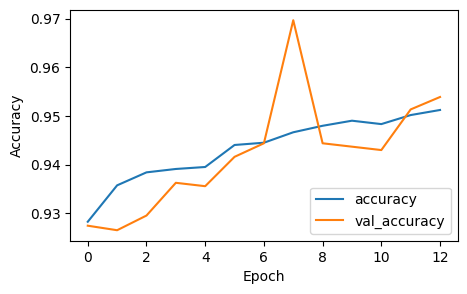

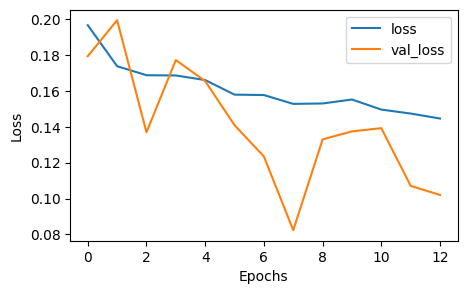

In [17]:
print_courbes(history)

#### Analyse des résultats

Nous pouvons voir que le modèle commence avec de bonnes performances.

L'accuracy augmente progressivement de 0.93 à 0.95 pour les données d'entrainement, indiquant une bonne adaptation du modèle aux données d'entrainement.  
De même pour l'accuracy pour les données de validation, même si elle fluctue un peu plus. 

Si nous nous interressons à la perte, nous pouvons voir que la perte pour les données d'entrainement diminue doucement de façon régulière, de même pour les données de validation.

Ce modèle est simple et est composé de peu de couches, nous allons essayer d'améliorer ce modèle en y ajoutant une couche de convolution, même s'il présente déjà une bonne accuracy sur les données d'entrainement et de validation.

### Deuxième modèle : conv + conv + pooling

Nous allons maintenant tenter d'ajouter une couche de convolution à notre premier modèle, afin de déterminer si celui-ci est plus performant.

Cette nouvelle couche devrait permettre de capturer plus de caractéristiques et d'améliorer la précision du modèle sur les données de validation.

In [18]:
# Définition du modele
model2 = Sequential()
model2.add(Input(shape=(window_size, 5))) 
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # couche de convolution ajoutée
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(len(np.unique(labels)), activation='softmax'))

#### Compilation du modèle

In [19]:
# Compiler le modèle
model2.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 23, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        64,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,123 (277.82 KB)

 Trainable params: 71,123 (277.82 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle

In [20]:
# Entrainement du modèle
history2 = model2.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9041 - loss: 0.2627 - val_accuracy: 0.9215 - val_loss: 0.1822
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9310 - loss: 0.1841 - val_accuracy: 0.9316 - val_loss: 0.1902
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9333 - loss: 0.1879 - val_accuracy: 0.9365 - val_loss: 0.1393
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9416 - loss: 0.1796 - val_accuracy: 0.9208 - val_loss: 0.1433
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9440 - loss: 0.1625 - val_accuracy: 0.9472 - val_loss: 0.1689


#### Courbe d'apprentissage du deuxième modèle

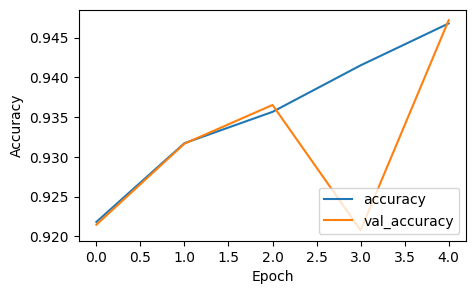

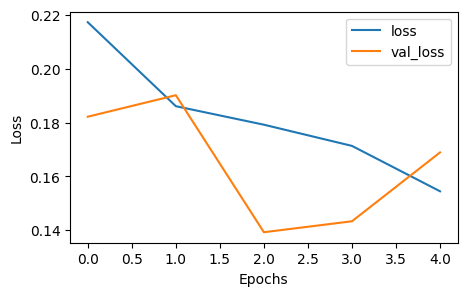

In [21]:
# Courbes d'apprentissage
print_courbes(history2)

#### Analyse des résultats

Ce modèle arrête l'entrainement plus rapidement que le premier, avec seulement 5 époques contre 13 pour le premier.

L'accuracy et la perte sont très bonnes pour les données d'entrainement et de perte, cependant, elles sont légèrement moins bonnes que pour le premier modèle.

### Troisième modèle : conv + conv + pooling + conv + pooling

Nous allons maintenant tenter d'ajouter un bloc composé d'une couche de convolution suivi d'une couche de pooling à notre deuxième modèle.  
Le but de cet ajout est de réduire la fluctuation, et de mieux généraliser sur les données.

In [22]:
# Définition du modèle
model3 = Sequential()
model3.add(Input(shape=(window_size, 5))) 
model3.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=128, kernel_size=3, activation='relu')) # couche de convolution ajoutée
model3.add(MaxPooling1D(pool_size=2)) # couche de pooling ajoutée
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(len(np.unique(labels)), activation='softmax'))

#### Compilation du modèle

In [23]:
# Compiler le modèle
model3.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 23, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,027 (324.32 KB)

 Trainable params: 83,027 (324.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle

In [24]:
# Entrainement du modèle
history3 = model3.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)


Epoch 1/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9078 - loss: 0.2693 - val_accuracy: 0.9326 - val_loss: 0.1455
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9286 - loss: 0.1992 - val_accuracy: 0.9361 - val_loss: 0.1465
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9407 - loss: 0.1761 - val_accuracy: 0.9537 - val_loss: 0.0928
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9478 - loss: 0.1746 - val_accuracy: 0.9588 - val_loss: 0.0773
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9490 - loss: 0.1598 - val_accuracy: 0.9476 - val_loss: 0.1176
Epoch 6/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9496 - loss: 0.1524 - val_accuracy: 0.9625 - val_loss: 0.0754
Epoch 7/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9513 - loss: 0.1528 - val_accuracy: 0.9430 - val_loss: 0.1733
Epoch 8/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9489 - loss: 0.1579 - val_accu

#### Courbe d'apprentissage du troisième modèle

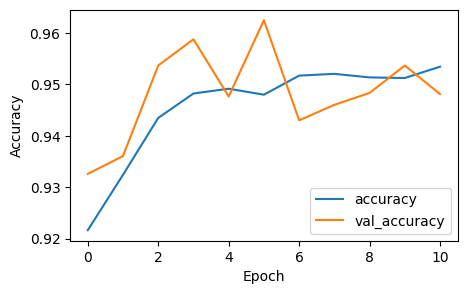

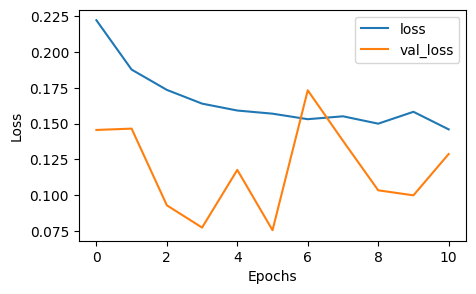

In [25]:
# Courbes d'apprentissage
print_courbes(history3)

#### Analyse des résultats

Nous pouvons voir que l'ajout des couches de convolution et de pooling a permis d'améliorer les valeurs d'accuracy et de loss par rapport au deuxième modèle. Les valeurs sont plus proches des valeurs du premier modèle.

Ce modèle semble donc mieux généraliser sur les données de validation par rapport au modèle précédent, même si les métriques obtenues avec les données de validation fluctuent un peu plus que pour les données d'entrainement.

### Quatrième modèle : conv + conv + pool + conv + pool + dropout

Nous allons maintenant réaliser un dernier modèle en ajoutant une couche dropout à notre troisième modèle.  
Le but de cet ajout est de réduire la fluctuation, et de mieux généraliser sur les données de validation.

In [26]:
# Définition du modele
model4 = Sequential()
model4.add(Input(shape=(window_size, 5))) 
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.5)) # couche de dropout ajoutée
model4.add(Dense(len(np.unique(labels)), activation='softmax'))

#### Compilation du modèle

In [27]:
# Compiler le modèle
model4.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 23, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,027 (324.32 KB)

 Trainable params: 83,027 (324.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle

In [28]:
# Entrainement du modèle
history4 = model4.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9007 - loss: 0.2206 - val_accuracy: 0.9289 - val_loss: 0.1260
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9377 - loss: 0.1282 - val_accuracy: 0.9314 - val_loss: 0.1222
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9338 - loss: 0.1270 - val_accuracy: 0.9435 - val_loss: 0.1049
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9465 - loss: 0.1043 - val_accuracy: 0.9439 - val_loss: 0.1017
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9493 - loss: 0.0959 - val_accuracy: 0.9488 - val_loss: 0.0871


#### Courbe d'apprentissage du quatrième modèle

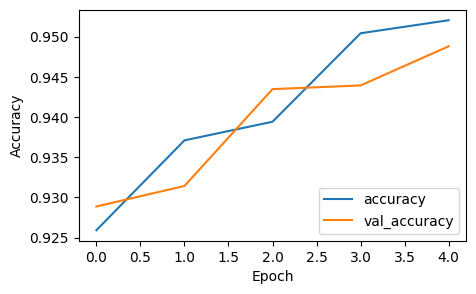

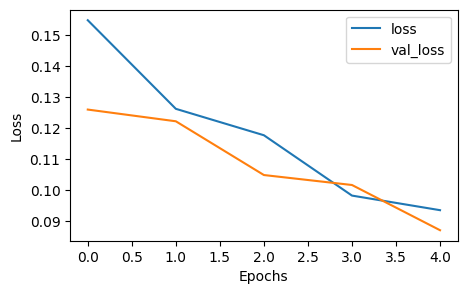

In [29]:
# Courbes d'apprentissage
print_courbes(history4)

#### Analyse des résultats

Nous pouvons voir clairement une amélioration par rapport au modèle précédent. En effet, les valeurs de perte et d'exactitude fluctuent nettement moins sur les données de validation.  
De plus, la valeur de perte est meilleure que pour les 3 autres modèles. 

Le modèle semble être mieux adapté aux données, et mieux généraliser.

## Utilisation des modèles sur les données de test

Nous allons maintenant analyser nos deux meilleurs modèles, les modèles 1 et 4, sur nos données de test.

In [30]:
# Affichage de la matrice de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

#### Sélection aléatoire de 1000 points

Nous commençons par selectionner aléatoirement 1000 points parmis les données de test.

In [31]:
x_test_1000, y_test_1000 = resample(x_test, y_test, n_samples=1000, random_state=42, replace=False)

#Afficher répartition des classes
print(np.unique(y_test_1000, return_counts=True))

(array([0, 1, 2], dtype=int64), array([ 72, 582, 346], dtype=int64))


### Utilisation du modèle 1 sur les données de test

Nous appliquons maintenant notre premier modèle aux données, et comparons la classe prédite à la classe réelle.

In [32]:
y_pred = model.predict(x_test_1000)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### Résultats statistiques obtenus sur les données de test

In [33]:
print("accuracy :", accuracy_score(y_test_1000, y_pred_classes))
print("precision :", precision_score(y_test_1000, y_pred_classes, average='weighted'))
print("rappel :", recall_score(y_test_1000, y_pred_classes, average='weighted'))
print("f1-score :", f1_score(y_test_1000, y_pred_classes, average='weighted'))

accuracy : 0.972
precision : 0.975640783898305
rappel : 0.972
f1-score : 0.9724875831462861


#### Matrice de confusion

matrice de confusion :
[[ 72   0   0]
 [  0 581   1]
 [ 18   9 319]]


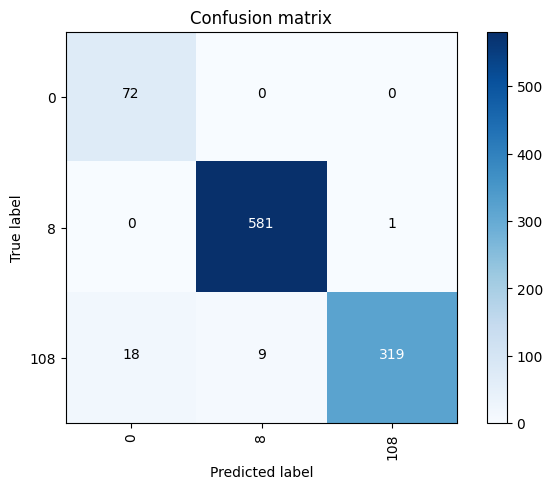

In [34]:
confusion_mtx = confusion_matrix(y_test_1000, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = ['0','8','108'])

print("matrice de confusion :")
print(confusion_matrix(y_test_1000, y_pred_classes))

#### Analyse

Le modèle 1 montre des résultats plus que satisfaisant sur le jeu de données de test.  

Même si c'est un modèle simple, il obtient une valeur d'exactitude (accuracy) de 97.2% et une valeur de précision de 97.6%. Cela montre que le modèle fonctionne très bien sur les données de test.  
Le rappel de 97.2% est également très bon, montrant que les classes sont bien détectées, et le score f1 de 0.972 démontre que l'équilibre entre la précision et le rappel est bien respecté.

La matrice de confusion montre cependant que le modèle a plus de mal à généraliser sur les données appartenant à la classe 108, contrairement aux classes 0 et 8 qui sont parfaitement reconnues.

### Test du modèle 4 sur les données de test

Nous appliquons maintenant notre quatrième modèle aux données de test, et comparons la classe prédite à la classe réelle.

In [35]:
y_pred = model4.predict(x_test_1000)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#### Résultats statistiques obtenus sur les données de test

In [36]:
print("accuracy :", accuracy_score(y_test_1000, y_pred_classes))
print("precision :", precision_score(y_test_1000, y_pred_classes, average='weighted'))
print("rappel :", recall_score(y_test_1000, y_pred_classes, average='weighted'))
print("f1-score :", f1_score(y_test_1000, y_pred_classes, average='weighted'))

accuracy : 0.926
precision : 0.9451003815620329
rappel : 0.926
f1-score : 0.9297777226114157


#### Matrice de confusion

matrice de confusion :
[[ 72   0   0]
 [  0 570  12]
 [ 51  11 284]]


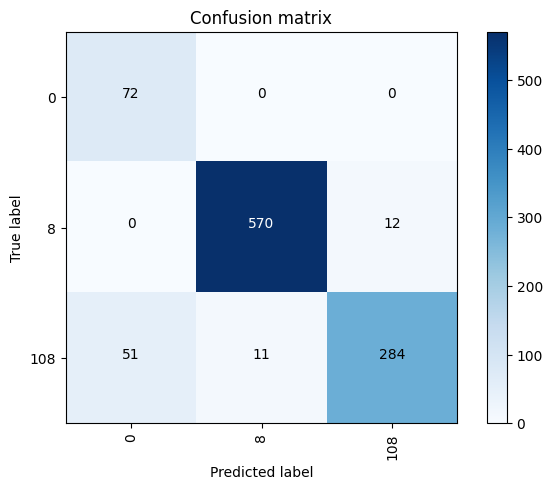

In [37]:
confusion_mtx = confusion_matrix(y_test_1000, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = ['0','8','108'])

print("matrice de confusion :")
print(confusion_matrix(y_test_1000, y_pred_classes))

#### Analyse

Ce modèle, bien que moins performant que le précédent, obtient de très bons scores. Avec une accuracy de 92.6%, une valeur de précision de 94.5%, une valeur de rappel de 92.6% et un score f1 de 0.930.

On peut également voir que le modèle a plus de mal à classer correctement les instances de la classe 108, ainsi que quelques instances de la classe 8.

## Conclusion

Les modèles développés montrent de bonnes performances globales et réussissent à généraliser efficacement sur de nouvelles données.

Cependant, ils ont certaines difficultés à classifier correctement les instances de la classe 108.  

Cette difficulté pourrait être du au fait que les attributs caractérisant la classe 108 ont des valeurs qui se situent entre les valeurs associées aux classe 0 et 8.  
Les modèles pourraient donc avoir plus de difficultés a identifier les limites précises de ces classes.